In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os.path import join

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Structural evolution of multilayer GCN

In order to assess the structural evolution involved in the co-expression program, we:

1. Set the structural measures of interest
2. Show their differences in terms of healthy and breast cancer tissues
3. Show their relation to chromosomal connectivity
4. Identify a known network-generator mechanism

In [6]:
DATA = "/Users/rdora/breast_cancer/data/"
FIG = "/Users/rdora/Dropbox/inmegen/breast_cancer/article/figures/"

In [7]:
df = pd.read_csv(join(DATA, "netparams_tidy.csv"))

In [8]:
df = df[df.Tissue.isin(["Healthy", "Basal"])]

In [9]:
df = df[df.Param != "A.A"]

In [10]:
df = df[df.Layer >= 0]

In [11]:
df.loc[df.Param=="Size", "Value"] = df.loc[df.Param=='Size', "Value"] / 1000

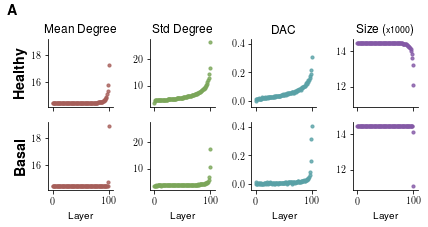

In [12]:
# FacetGrid
with sns.hls_palette(4, l=.5, s=.3):
    g = sns.FacetGrid(col="Param",
                 row="Tissue",
                 hue="Param",
                 data=df,
                 sharey="col",
                 height=1.5,
                 aspect=1,
                 margin_titles=True)

    g.map(plt.scatter, "Layer", "Value", alpha=0.8, s=10, marker='o')
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '', col_template = '{col_name}')

# Change y axis
g.axes[0,0].set_ylabel(r'\textbf{\Large Healthy}')
g.axes[1,0].set_ylabel(r'\textbf{\Large Basal}')

g.fig.text(0, 1, r'\textbf{\Large A}', fontweight='bold')
g.axes[0,0].set_title(r'Mean Degree')
g.axes[0,1].set_title('Std Degree')
g.axes[0,2].set_title('DAC')
g.axes[0,3].set_title(r'Size ({\small x1000})')
# g.axes[3,0].set_ylabel('Size (x1000)')

# SaveFig
g.savefig(join(FIG, "structure_evolution.png"), dpi=300)

# Structural measures: Values

Deviation from noise.

In [13]:
tissues = df.Tissue.unique()
measures = df.Param.unique()
random = [[14.449772, 14.511538],
          [3.831434, 3.823713],
          [-0.003132, -0.002048],
          [14.474000, 14.474000]]
data = []
for tissue in tissues:
    for i, measure in enumerate(measures):
        vals = df[(df.Tissue==tissue) & (df.Param==measure)]['Value'].values
        if tissue == 'healthy':
            norm1 = np.abs((vals - random[i][0]).sum())
        else:
            norm1 = np.abs((vals - random[i][1]).sum())
        data.append([tissue, measure, norm1])
df_norm1 = pd.DataFrame(data, columns=['tissue', 'Measure', 'norm1'])

In [14]:
(df[(df.Tissue=='Healthy') & (df.Param=='Size')]['Value'].values - 14.474000).sum()

-8.241000000000012

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


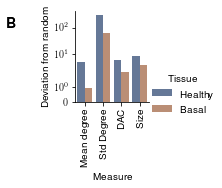

In [15]:
replace = {'Mean Deg': 'Mean degree',
          'Std Deg': 'Std Degree',
          'D.A': 'DAC'}
df_norm1 = df_norm1.replace(replace)
df_norm1 = df_norm1.rename(columns={'tissue': 'Tissue'})
with sns.color_palette('deep'):
    g = sns.catplot(x="Measure", y="norm1",
                    hue="Tissue",
                 data=df_norm1, saturation=.5,
                 kind="bar", ci=None, aspect=1,
                   height=2)
g.set(yscale = 'symlog')
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
#g.set_titles(row_template = '', col_template = '{col_name}')
g.set_xticklabels(rotation=90)
# Labels and titles
g.axes[0,0].set_ylabel('Deviation from random')


g.fig.text(0, .8, r'\textbf{\Large B}', fontweight='bold')

g.savefig(join(FIG, "structural_deviation.png"), dpi=300)

In [16]:
tissues = df.Tissue.unique()
measures = df.Param.unique()
random = [[14.449772, 14.511538],
          [3.831434, 3.823713],
          [-0.003132, -0.002048],
          [14.474000, 14.474000]]
data = []
df_95 = df[df.Layer < 95]
for tissue in tissues:
    for i, measure in enumerate(measures):
        vals = df_95[(df_95.Tissue==tissue) & (df_95.Param==measure)]['Value'].values
        if tissue == 'Healthy':
            norm1 = np.abs((vals - random[i][0]).sum())
        else:
            norm1 = np.abs((vals - random[i][1]).sum())
        data.append([tissue, measure, norm1])
df_95_norm1 = pd.DataFrame(data, columns=['tissue', 'Measure', 'norm1'])

Text(9.567408473108655, 0.5, 'Deviation from random')

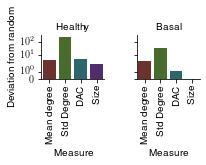

In [17]:
replace = {'Mean Deg': 'Mean degree',
          'Std Deg': 'Std Degree',
          'D.A': 'DAC'}
df_95_norm1 = df_95_norm1.replace(replace)
with sns.hls_palette(4, l=.3, s=.8):
    g = sns.catplot(x="Measure", y="norm1", col="tissue",
                 data=df_95_norm1, saturation=.5,
                 kind="bar", ci=None, aspect=1,
                   height=1.5)
g.set(yscale = 'symlog')
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '', col_template = '{col_name}')
g.set_xticklabels(rotation=90)
g.axes[0,0].set_ylabel('Deviation from random')

# g.savefig(join(FIG, "structural_deviation.png"), dpi=300)

# Relation between DAC and AAC

In [18]:
df_net = pd.read_csv(join(DATA, 'net_params_clean.csv'))

In [19]:
df_net = df_net[df_net.Layer >= 0]
df_net = df_net[df_net.Tissue.isin(['Healthy', 'Basal'])]

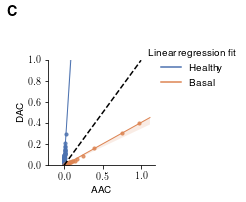

In [21]:
x = np.linspace(0, 1, 1000)

with sns.color_palette('deep'):
    g = sns.lmplot(x="A.A", y="D.A",
                   hue="Tissue", data=df_net,
                   height=2.2, aspect=1, scatter_kws={"s": 10},
                   line_kws={"linewidth": 1}, legend=False)

# Set limits
g.axes[0,0].set_ylim(0, 1)


g.axes[0,0].set_xlabel('AAC')
g.axes[0,0].set_ylabel('DAC')

g.axes[0,0].plot(x, x, linestyle='--', c='k')

# New legend
l1, = plt.plot([], [], linestyle="-", color=(
    0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
             label="Healthy")

l2, = plt.plot([], [], linestyle="-", color=(
    0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
             label="Basal")

first_legend = plt.legend(handles=[l1, l2], loc=(0.9, 0.7),
                         frameon=False, title="Linear regression fit")


# Letter
g.fig.text(0, 1.2, r'\textbf{\Large C}', fontweight='bold')

g.savefig(join(FIG, 'assortativity_relation.png'), dpi=300)

## Regressor

In [344]:
regressor = LinearRegression()

In [381]:
X = df_net[df_net.Tissue=='Healthy']['A.A'].values.reshape(101, 1)
y = df_net[df_net.Tissue=='Healthy']['D.A'].values.reshape(101, 1)
regressor.fit(X, y)

print("Slope:", regressor.coef_[0][0])

print("Intercept:", regressor.intercept_[0])

Slope: 11.32193523692171
Intercept: 0.01485897791078479


In [382]:
y_pred = regressor.predict(X)
mean_squared_error(y, y_pred)

0.00018429275557905176

In [383]:
X = df_net[df_net.Tissue=='Basal']['A.A'].values.reshape(101, 1)
y = df_net[df_net.Tissue=='Basal']['D.A'].values.reshape(101, 1)
regressor.fit(X, y)

print("Slope:", regressor.coef_[0][0])

print("Intercept:", regressor.intercept_[0])

Slope: 0.40728236426535747
Intercept: 0.0002431473442160957


In [384]:
y_pred = regressor.predict(X)

mean_squared_error(y, y_pred)

1.5268091475159953e-05